<a href="https://colab.research.google.com/github/amthreeh/-AI-SPARK-air_compressor/blob/main/autoencoder_0_915.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pwd

'/content'

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [4]:
# train 데이터 불러오기
train_data = pd.read_csv('drive/MyDrive/공기압축기/train_data.csv')

# 특성 변수 선택
features = ['air_inflow', 'air_end_temp', 'out_pressure', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe']

# 특성 변수를 정규화하여 X 데이터로 만들기
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data[features])


In [5]:
from keras.layers import Input, Dense
from keras.models import Model

# 입력층
input_layer = Input(shape=(len(features),))

# 인코더
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)

# 디코더
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(len(features), activation=None)(decoded)

# Autoencoder 모델
autoencoder = Model(input_layer, decoded)

# 인코더 모델
encoder = Model(input_layer, encoded)


In [6]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
70/70 [==============================] - 2s 5ms/step - loss: 0.6939 - val_loss: 0.1051
Epoch 2/50
70/70 [==============================] - 0s 2ms/step - loss: 0.1566 - val_loss: 0.0118
Epoch 3/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0562 - val_loss: 0.0040
Epoch 4/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0012
Epoch 5/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 7.0143e-04
Epoch 6/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 3.5790e-04
Epoch 7/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 2.8030e-04
Epoch 8/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 2.0870e-04
Epoch 9/50
70/70 [==============================] - 0s 2ms/step - loss: 8.1204e-04 - val_loss: 2.5813e-04
Epoch 10/50
70/70 [==============================] - 0s 2ms/step - loss: 7.1834e-04 - val_loss

77/77 [==============================] - 0s 3ms/step


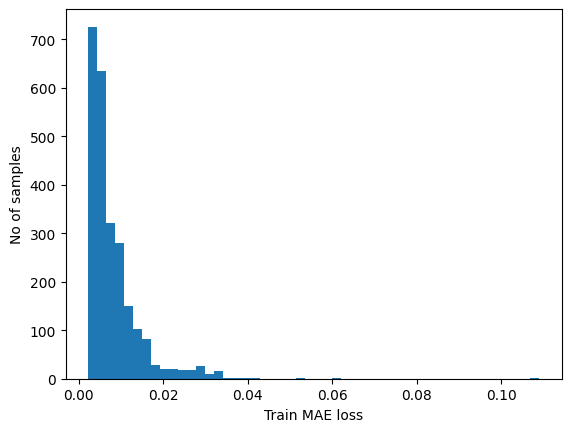

231/231 [==============================] - 0s 2ms/step


In [10]:
# train 데이터의 재구성 오차 구하기
X_train_pred = autoencoder.predict(X_train)
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['mae_loss'])
train_mae_loss.describe()

# 재구성 오차의 분포 시각화
import matplotlib.pyplot as plt
plt.hist(train_mae_loss['mae_loss'], bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('No of samples')
plt.show()

# 재구성 오차의 임계치 설정하기
threshold = train_mae_loss.quantile(0.99)['mae_loss']

# test 데이터 불러오기 및 전처리
test_data = pd.read_csv('drive/MyDrive/공기압축기/test_data.csv')
X_test = scaler.transform(test_data[features])

# test 데이터에 대한 예측
X_test_pred = autoencoder.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

# 이상치 판단하기
test_data['anomaly'] = test_mae_loss > threshold
anomalies = test_data.loc[test_data['anomaly'] == True]


In [12]:
print(test_data['anomaly'])

0       False
1       False
2       False
3       False
4       False
        ...  
7384    False
7385    False
7386    False
7387    False
7388    False
Name: anomaly, Length: 7389, dtype: bool


In [13]:
print(anomalies)

      air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
585         1.38         41.64           0.7          21.10     1651.0   
586         2.06         51.95           0.7          31.64     2476.0   
587         1.35         41.20           0.7          20.65     1616.0   
588         2.86         63.93           0.7          43.88     3434.0   
589         1.62         45.26           0.7          24.80     1941.0   
...          ...           ...           ...            ...        ...   
6800        1.44         50.90           0.7          27.05     2072.0   
7342        1.60         45.04           0.7          24.57     1923.0   
7348        2.76         62.36           0.7          42.28     3309.0   
7359        1.48         43.15           0.7          22.64     1772.0   
7360        1.74         47.05           0.7          26.63     2084.0   

      motor_temp  motor_vibe  type  anomaly  
585        58.34        3.12     0     True  
586        59.34   

In [14]:
# label 작성하기
test_data['label'] = test_data['anomaly'].apply(lambda x: 1 if x else 0)

# answer_sample.csv 파일로 저장하기
test_data[['type', 'label']].to_csv('answer_sample.csv', index=False)
